In [1]:
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/contracts.csv',sep=';', header=None, names=['contract','service_id','service_name','user_request'])

In [3]:
data.head()

,contract,service_id,service_name,user_request
0,354,4,Сантехник,лалсо
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
3,379,14,Муж на час,для Ерлана
4,385,14,Муж на час,мастер мастеров


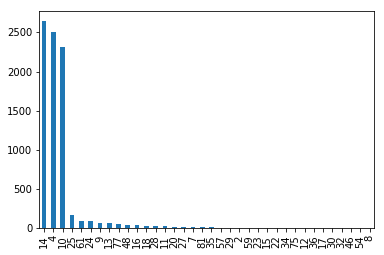

In [4]:
data.service_id.value_counts().plot(kind='bar')

In [5]:
data4 = data[~data.service_id.isin([14,10,4])].copy()
data4.head()

,contract,service_id,service_name,user_request
1,364,16,Сборка и ремонт мебели,заказ для Александра Трушкина
2,370,13,Ремонт компьютеров,заказ для Алишера
9,550,13,Ремонт компьютеров,где фото?
11,568,13,Ремонт компьютеров,видно имя?
13,573,13,Ремонт компьютеров,рейтинг нулевой


In [6]:
data.loc[~data.service_id.isin([14,10,4]), 'service_id'] = 0

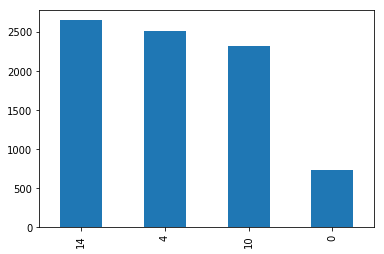

In [7]:
data.service_id.value_counts().plot(kind='bar')

In [8]:
vc = data4.service_id.value_counts().sort_values(ascending=False)[5:].index.tolist()
ind = data4[data4['service_id'].isin(vc)].index
data4.drop(ind, inplace=True)

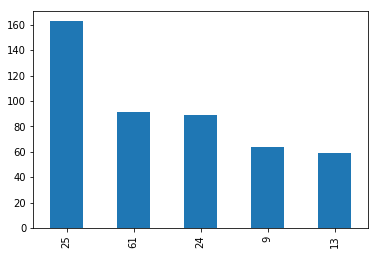

In [9]:
data4.service_id.value_counts().plot(kind='bar')

In [10]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^а-я ]')

In [11]:
def remove_stopwords(text: str) -> str:
        try:
            text = text.lower()
            text = REPLACE_BY_SPACE_RE.sub(' ', text)
            text = BAD_SYMBOLS_RE.sub('', text)
            return " ".join([token for token in text.split() if token not in mystopwords])
        except:
            return ""
        
def lemmatize(text: str) -> str:
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def remove_stoplemmas(text: str) -> str:
    try:
        return " ".join([token for token in text.split() if token not in mystoplemmas])
    except:
        return ""

def clear_text(text: str) ->str:
    cText = remove_stopwords(text)
    cText = lemmatize(cText)
    cText = remove_stoplemmas(cText)
    return cText

In [12]:
from pymystem3 import Mystem

In [13]:
m = Mystem()

In [14]:
import smart_open
import nltk
from gensim.test.utils import datapath
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш', 'тыс', 'млн', 'млрд', 'также',  'т', 'д','iKomek.kz','кв']
mystoplemmas = ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь']

[nltk_data] Downloading package stopwords to /home/mic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from fastText import FastText as FT

In [17]:
model1 = FT.train_unsupervised(input='data/lemmas.txt', dim=50, epoch=100)

In [18]:
vectors = []
for index, row in data.iterrows():
    l = clear_text(row['user_request'])
    vector = model1.get_sentence_vector(l)
    vectors.append(vector)

In [19]:
from sklearn.model_selection import train_test_split

In [21]:
Y = data.service_id
X_train, X_test, y_train, y_test = train_test_split(vectors, Y, test_size=0.33, random_state=42)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [23]:
param = [
         {"C":[5,10,50], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']},
         {"C":[5,10,50],'penalty': ['l2'], 'solver': ['newton-cg'] }
        ]
model = LogisticRegression(multi_class = 'auto', max_iter = 200)
cv = GridSearchCV(model, param, cv = 3, n_jobs = 7)
cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", cv.best_params_)
print("accuracy :", cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.752594210813763


In [31]:
from sklearn.metrics import *
import seaborn as sns

In [35]:
def print_result(model, text, x_test, y_true, cv, proba=True):
    print('Predicted service ID: ', model.predict([text]))
    if proba:
        pred_service = model.predict_proba([text])
        print('Predic_proba : ', pred_service)
    predictions = model.predict(x_test)
    print("Precision: {0:6.2f}".format(precision_score(y_true, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_true, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_true, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_true, predictions)))
    print(classification_report(y_true, predictions))
    labels = cv.best_estimator_.classes_
    sns.heatmap(data=confusion_matrix(y_true, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

In [36]:
test_text = 'генеральная уборка 4-х комнатной квартиры'
test_lemmas = clear_text(test_text)
print(test_lemmas)
test_vector = model1.get_sentence_vector(test_lemmas)
print(test_vector)

генеральный уборка х комнатный квартира
[-0.1946544   0.06222115 -0.09672704 -0.21613017  0.08933946 -0.03780379
  0.16778243  0.23382702 -0.04189274  0.04363266 -0.00360325  0.031106
  0.06768193 -0.01362341  0.00044305 -0.03927359 -0.08103218 -0.01940151
  0.08513712  0.0201978  -0.06261119  0.10410285  0.12646051 -0.14597975
 -0.00889453  0.02689093 -0.2116007   0.00907183 -0.12512855  0.08984988
  0.0039651  -0.08668192 -0.14163707 -0.05497378 -0.13450825 -0.06517221
 -0.18253496 -0.0556117   0.0284525   0.0187328   0.0098746   0.10450087
  0.01163134  0.10370503 -0.02378741 -0.02578911 -0.09878498 -0.0317276
  0.08433563 -0.02544507]


Predicted service ID:  [0]
Predic_proba :  [[0.43788302 0.02789225 0.12811599 0.40610875]]
Precision:   0.74
Recall:   0.71
F1-measure:   0.72
Accuracy:   0.75
              precision    recall  f1-score   support

           0       0.70      0.50      0.59       251
           4       0.72      0.86      0.79       828
          10       0.78      0.89      0.83       735
          14       0.75      0.59      0.66       892

   micro avg       0.75      0.75      0.75      2706
   macro avg       0.74      0.71      0.72      2706
weighted avg       0.74      0.75      0.74      2706



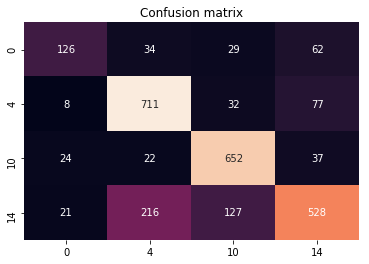

In [37]:
print_result(cv,test_vector,X_test,y_test,cv)

In [50]:
param = {"n_estimators":[5,10,50], 'max_depth': [5,10,20]}      
model = RandomForestClassifier(min_samples_leaf=20, max_features=0.5)
rf = GridSearchCV(model, param, cv = 3, n_jobs = 7)
rf.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", rf.best_params_)
print("accuracy :", rf.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 20, 'n_estimators': 50}
accuracy : 0.7300200254869834


Predicted service ID:  [0]
Predic_proba :  [[0.43178975 0.06906088 0.1148409  0.38430847]]
Precision:   0.78
Recall:   0.69
F1-measure:   0.71
Accuracy:   0.73
              precision    recall  f1-score   support

           0       0.93      0.45      0.61       251
           4       0.70      0.84      0.76       828
          10       0.73      0.87      0.79       735
          14       0.74      0.59      0.66       892

   micro avg       0.73      0.73      0.73      2706
   macro avg       0.78      0.69      0.71      2706
weighted avg       0.74      0.73      0.72      2706



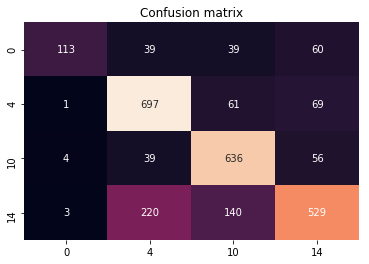

In [51]:
print_result(rf,test_vector,X_test,y_test,rf)

In [52]:
param = [
    {"loss":['hinge','squared_hinge'], 'penalty': ['l2']},
]
model = LinearSVC()
svc = GridSearchCV(model, param, cv = 3)
svc.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", svc.best_params_)
print("accuracy :", svc.best_score_)

/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


tuned hpyerparameters :(best parameters)  {'loss': 'squared_hinge', 'penalty': 'l2'}
accuracy : 0.7547788093937738


Predicted service ID:  [0]
Precision:   0.75
Recall:   0.71
F1-measure:   0.71
Accuracy:   0.75
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       251
           4       0.72      0.87      0.79       828
          10       0.77      0.90      0.83       735
          14       0.76      0.59      0.67       892

   micro avg       0.75      0.75      0.75      2706
   macro avg       0.75      0.71      0.71      2706
weighted avg       0.75      0.75      0.74      2706



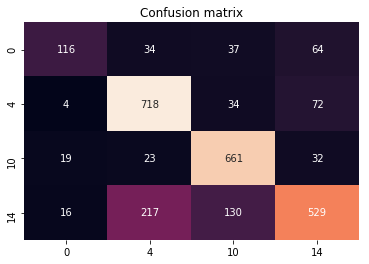

In [53]:
print_result(svc,test_vector,X_test,y_test,svc, False)

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
param = [
    {'n_neighbors': [5, 10, 50]},
]
model = KNeighborsClassifier()
kn = GridSearchCV(model, param, cv = 3)
kn.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ", kn.best_params_)
print("accuracy :", kn.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 10}
accuracy : 0.7687966502821774


In [60]:
from mlxtend.classifier import StackingClassifier

In [61]:
clf1 = KNeighborsClassifier(n_neighbors=10)
clf2 = RandomForestClassifier(max_depth = 20, n_estimators = 50, random_state=1)
lr = LogisticRegression(C = 50, penalty = 'l1', solver = 'liblinear')
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                          meta_classifier=lr)
sclf.fit(X_train, y_train)

/var/www/pvm/jupiter/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


StackingClassifier(average_probas=False,
          classifiers=[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='au...timators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)],
          drop_last_proba=False,
          meta_classifier=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [62]:
print("accuracy :",sclf.score(X_test, y_test))

accuracy : 0.7479674796747967


Predicted service ID:  [0]
Predic_proba :  [[4.73718355e-01 4.69254248e-01 5.70226827e-02 4.71425609e-06]]
Precision:   0.78
Recall:   0.72
F1-measure:   0.74
Accuracy:   0.75
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       251
           4       0.72      0.83      0.77       828
          10       0.78      0.86      0.81       735
          14       0.72      0.64      0.68       892

   micro avg       0.75      0.75      0.75      2706
   macro avg       0.78      0.72      0.74      2706
weighted avg       0.75      0.75      0.74      2706



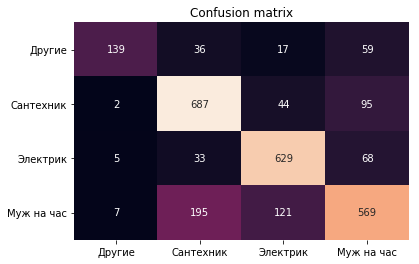

In [69]:
print('Predicted service ID: ', sclf.predict([test_vector]))
pred_service = sclf.predict_proba([test_vector])
print('Predic_proba : ', pred_service)
predictions = sclf.predict(X_test)
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = ['Другие','Сантехник','Электрик','Муж на час']
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()